

# Linear Model (Workbook)

### ITCS 4156:  Introduction to Machine Learning 

# Goal 

The goal of this activity is to practice our first machine learning models, least squares (LS) and least means squares (LMS), by applying them to real data. We will prepare data as we did in last week's practice and then apply these linear models. We'll also take a look at a few more data processing tricks we typically need to apply to data. Follow the TODO titles and comments to finish the activity!

# Agenda

* Data visualization
* Data preprocessing
* Implementing least squares (LS)
* Normalization
* Creating indicator variables
* Implementing least means squared
* Data Partitioning


# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Reading forest fire data

Just like the last lab we will use the forest fires data. Our goal will be to predict the 'area' feature, which corresponds to area of the forest burned. We will use the remaining features as our input features to make the predictions.

### Downloading via Linux and Mac

If you are using Linux or Mac feel free to use the following `curl` command to download the data again.

**NOTE: This command will only work on Linux and Mac. If you are using Windows feel free to try running the cell but don't expect it to work!**

In [2]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv -o forestfires.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25478  100 25478    0     0  69233      0 --:--:-- --:--:-- --:--:-- 69233


### Downloading via Windows
Here is the repository where you can redownload the data if you are using Windows: https://archive.ics.uci.edu/ml/datasets/Forest+Fires.

**NOTE: Make sure once you have downloaded the data that you put the `forestfires.csv` file in the same directory as this notebook!**

### TODO

* Using Pandas, read the `forestfires.csv` dataset into the variable `df`. 

In [3]:
# TODO: Using pandas, read the `forestfires.csv` dataset into a variable named `df`.
df = pd.read_csv("forestfires.csv")
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


## Visualize the data
Adding to the visualization we practiced last week, let's use the data to now visualize the burned areas at any given location in Montesinho park. Luckily, the data provides us with some simple x-y coordinates for every sample in the data. Thus, we can use these x-y coordinates to make a contour graph where brighter colors indicate larger amounts of burned forest area at a given x-y point.

In order to create a contour graph we need to create a mesh-grid. This essentially allows us to make a Cartesian coordinate system. This mesh-grid will be required by the `plt.contourf()` function in order to match the x-y coordinates to the total burned forest area at each coordinate point.

Here we can see the x-y coordinates and the burned forest area for each data sample. Notice, there are duplicates of the x-y coordinates. This means multiple data samples can have the same x-y coordinates. This will be important when calculating the total burned forest area at a given x-y coordinate!

In [4]:
df.loc[:, ['X', 'Y', 'area']]

,X,Y,area
0,7,5,0.00
1,7,4,0.00
2,7,4,0.00
3,8,6,0.00
4,8,6,0.00
...,...,...,...
512,4,3,6.44
513,2,4,54.29
514,7,4,11.16
515,1,4,0.00


### Creating the mesh-grid

Here we create a mesh-grid using `np.meshgrid`. Before we do so we have to specify the domain for the x-axis and y-axis. We can generate the x-axis and y-axis domains by using Numpy's `np.arange()` function. The `np.arange()` function will generate a Numpy array object filled with integers up to, but not including, the given 'stop' number.

To generate the x-axis and y-axis domains we first need to know the maximum and minimum values for the columns 'X' and 'Y'. Otherwise, how would we know where to begin or end the x-axis and y-axis? 

To find the maximum of 'X' and 'Y' values in the data we use the following code. Here we can see that both max values are 9!

In [5]:
df.loc[:, ['X', 'Y']].max(axis=0)

X    9
Y    9
dtype: int64

Here is the code for finding the minimum values. The minimum values here are 1 and 2!

In [6]:
df.loc[:, ['X', 'Y']].min(axis=0)

X    1
Y    2
dtype: int64

In the below code we set our minimum domain element to 0 `start=0` as 0 is sufficiently low enough for both 'X' and 'Y’ according to the minimums given above . Next, we set our maximum domain for both 'X' and 'Y’ to 10 `stop=11` as 10 is sufficiently high enough according to the maximums.

In [7]:
x_domain, y_doamin = np.arange(start=0, stop=11), np.arange(start=0, stop=11)
print("Domain for the x-axis: {}".format(x_domain))
print("Domain for the y-axis: {}".format(y_doamin))

Domain for the x-axis: [ 0  1  2  3  4  5  6  7  8  9 10]
Domain for the y-axis: [ 0  1  2  3  4  5  6  7  8  9 10]


Now it's time to see what exactly a mesh-grid is! Here, we input both `x_domain` and `y_domain` into `np.meshgrid()` to create a mesh-grid which outputs two more Numpy arrays. The variable `xs` corresponds to the x-axis of the mesh-grid while `ys` corresponds to the y-axis of the mesh-grid. Together these two Numpy arrays make a mesh-grid!

In [8]:
xs, ys = np.meshgrid(x_domain, y_doamin)

In [9]:
xs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])

In [10]:
ys

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

### Calculating total burned forest area
Now, we need to calculate the totaled burned forest area for each unique x-y coordinate in our dataset. To make our lives easier let's first filter out all the data samples that have 0 burned forest area. In addition, let's go ahead and extract out only the 'X', 'Y', and 'area' columns.

In [11]:
burned = df.loc[df.loc[:, 'area'] > 0, ['X', 'Y', 'area']]
burned

,X,Y,area
138,9,9,0.36
139,1,4,0.43
140,2,5,0.47
141,1,2,0.55
142,8,6,0.61
...,...,...,...
509,5,4,2.17
510,6,5,0.43
512,4,3,6.44
513,2,4,54.29


Finally, we can calculate the total burned forest area for each unique x-y coordinate. To track the total burned forest area we want to map each x-y coordinate to the sum of the burned forest area at a given coordinate. To do so we need to create a total burned forest area Numpy array called `zs`. We can simply reuse the shape from `xs` or `ys` to make sure we cover every possible x-y coordinate point. To find the total burned forest area we iterate through the `burned` DataFrame adding the 'area’ value of each data sample to its corresponding x-y coordinate location in `zs`.

In [12]:
zs = np.zeros(xs.shape)
zs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

**It should be noted when mapping an array to x-y coordiantes the rows of the array correspond to the y-axis and the columns correspond to the x-axis!** It might help you to think about Numpy arrays as inverted coordinate planes, which look like the following image!

![inverted](https://support.cognex.com/docs/cvl_900/web/EN/cvl_users_guide/Content/Images/11_6.jpg)

In [13]:
fig = plt.figure()
zs = np.zeros(xs.shape)
i = 0
for _, sample in burned.iterrows():
    i+= 1
    x, y = int(sample['X']), int(sample['Y'])
    # print("x-y ({}, {}) = {}".format(x, y, sample['area']))
    zs[y, x] += sample['area']


<Figure size 432x288 with 0 Axes>

Here's what `zs` looks like after calculating the total burned forest area at each of the x-y coordinates.

In [14]:
pd.DataFrame(zs)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2,0.0,219.94,462.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
3,0.0,157.14,0.00,6.58,172.88,0.00,192.78,27.35,26.31,0.00,0.0
4,0.0,150.28,143.37,126.35,397.43,73.75,144.47,474.37,12.18,185.61,0.0
5,0.0,115.47,92.63,2.18,287.01,0.00,1384.05,77.39,2.93,8.16,0.0
6,0.0,0.00,0.00,0.00,87.73,17.62,8.59,86.45,1265.30,42.87,0.0
7,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
8,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,185.76,0.00,0.0
9,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.47,0.0


Now comes plotting. We can use `plt.contourf` function to plot the burned forest area at a given location. Here, brighter colors correspond to larger amounts of forest area burned.

Notice, that the `plt.contourf` successfully plotted our data in a normal coordinate plane even though our mesh-grid and `zs` were structured as inverted coordinate grids. We can thank Matplotlib for automatically converting our inverted plane, given via the Numpy arrays, to a normal plane!

If you are confused by anything up to this point please raise your hand and ask, send us an email, or create on post on Piazza! This goes for anything you encounter in the labs as well!

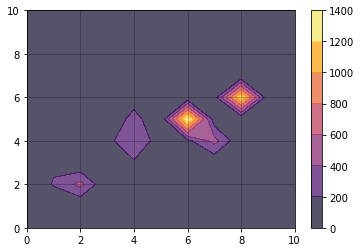

In [15]:
plt.contourf(xs, ys, zs, alpha=0.7, cmap=plt.cm.inferno,)
plt.colorbar()
plt.grid(c='k', ls='-', alpha=0.3)

Notice how all the bright areas on the contour plot have extremely high values (check  out the output of `pd.DataFrame(zs)` above for the exact numbers). This makes many of the other x-y coordinate points that have lower values for the total burned forest area harder to see. It's as if our data was skewed! If only there was a trick to deal with skewed data...

Right, there is a way! Remember from last week we took the log of our target 'area' to help alleviate its “skewedness”. Let's do the same thing again but now apply the log to `zs` our total burned forest area!


### TODO

- Take the log of `zs` storing it in a new variable `log_zs`
    - Don't forget you can't calculate log(0), try adding one to EVERY sample! If you only add 1 to  certain samples this biases the data!

In [16]:
log_zs = np.log(zs + 1)

Now run the following code to re-plot the contour plot with the logged values. Check out how much more colorful the graph is! This means we can see more smaller values for the total burned forest area than we could before.

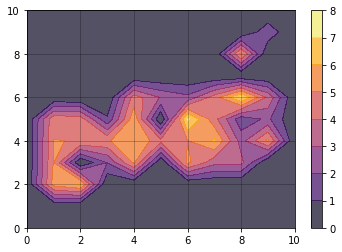

In [17]:
plt.contourf(xs, ys, log_zs, alpha=0.7, cmap=plt.cm.inferno)
plt.colorbar()
plt.grid(c='k', ls='-', alpha=0.3)

## Preprocessing the data
Before we can begin applying least squares our data needs to pass through some preprocessing steps. 

### Splitting data into input features and targets
Our first preprocessing step is to split our data into their given variables. `X` will be used for the input features, `T` for target labels, and `N` for the total number of samples in our data.


### TODO

* Assign `T` to the target column 'area'
* Assign `X` to all the input features, excluding the target column `area`
* Assign `N` to the total number of samples in our dataset

In [18]:
# TODO: Assign the three X, T, and N variables with proper values.
X = df.iloc[:, :-1]
T = df.iloc[:, -1]
N = df.shape[0]

### Dealing with strings
Remember the forest fire data has strings for the 'month' and 'day' columns. Thus, we must convert these columns to numerical values like we did last week.

### TODO

- Convert the string values in columns 'month' and 'day' to integers like we did last week.
    - Hint: Remember one way to do so is to use the Pandas DataFrame `.apply()` method in conjunction with a map and a function or lambda!

In [19]:
monthdic = {'jan': 1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
            'jul': 7, 'aug':8, 'sep':9, 'oct':10, 'nov': 11, 'dec': 12}
daydic = {'mon': 1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7 }

X['month'] = X['month'].apply(lambda x: monthdic[x])
X['day'] = X['day'].apply(lambda x: daydic[x])

In [20]:
# Convert to numpy arrays
X = X.values
T = T.values

### Alleviating a heavy tailed distribution
Once again it's time to fix our skewed target data `T` by taking the log of all the samples in `T`.

### TODO
- Take the log of `T` storing it in a new variable `Tlog`
    - Don't forget you can't calculate log(0), try adding one to EVERY sample! If you only add 1 to certain samples this biases the data!

In [21]:
# TODO: Take the log of zs storing it in a new variable log_zs
Tlog = np.log(T + 1)

### Adding the bias term to our data
Linear models embed a bias as one of the weights by adding 1's to the input `X`. The bias column allows for the least squares algorithm, and others, to create a solution that is not restricted to passing through the origin! Instead, the bias allows the soluition to shift the line of best fit up and down the Y-axis.

Think of a linear function $y = mx$ or more concretely an equation like $y = 5x$. This linear function is restricted to passing through the origin thus it can be harder to fit data. Now consider an affine function $y = mx + b$ or more concretely an equation like $y = 5x + 1$. This new affine function allows us to adjust the point at which our line of best fit intersects the y-axis (we are no longer confined to the origin). Essentially, adding the bias term is allowing for more flexibility in our models.

![](https://qph.fs.quoracdn.net/main-qimg-c0bb76e8e57e9a33170c45265eadb213)

### TODO
* Add the bias term, a vector of 1s, to the first column of the `X` and store the result in a new variable called `X1`.
    * Hint: To generate a vector of ones try using Numpy's `np.ones` function
    * Hint: Try using Numpy's [`np.hstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html) function to stack a **list** of arrays column wise.

In [22]:
bias = np.ones((N,1))
X1 = np.hstack([bias, X])

# Applying Least Squares
Now it's time to apply least squares to our data in an attempt to develop a model for predicting burned forest area! Recall that the least squares formula is used to generate weights $w$ which can then be used for making predictions given new data. The least squares  formula is given below where the symbol $\cdot$ corresponds to the dot product.

$$
w = (X^T \cdot X)^{-1} \cdot X^T \cdot T
$$

A quick note on Numpy symbol syntax regarding the dot product and element-wise multiplication. If you didn't know, you can use short hand symbols when trying to apply the dot product or element-wise multiplication to two Numpy arrays. The 'at' symbol `@` corresponds to the dot product or `np.dot()` and the 'astrick' `*` corresponds to element-wise multiplication.

## References
If you want to gain a better understanding of what least squares is doing check out the following references.
* [ Khan Academy](https://www.youtube.com/watch?v=MC7l96tW8V8)
* [Geometric view](https://medium.com/@andrew.chamberlain/the-linear-algebra-view-of-least-squares-regression-f67044b7f39b)


### TODO

* Apply least squares solution storing the output in the variable `w` using `X1` and `Tlog`
    * Hint: Use Numpy's `@` symbol or `np.dot` to compute the dot products.
    * Hint: Try using Numpy's [`linalg.pinv()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html) to calculate the pseudo inverse

In [23]:
# TODO: Apply the least squares solution storing the output in the variable w
""" 
The following code also works

w = np.linalg.lstsq(X1.T @ X1, X1.T @ Tlog)[0]
"""
X1_inverse = np.linalg.pinv(X1.T @ X1)
w = X1_inverse @ X1.T @ Tlog
w

array([-0.30477203,  0.0425947 , -0.00129011,  0.1550639 ,  0.00862479,
        0.00502995,  0.00240059, -0.00119776, -0.02492829,  0.00730238,
       -0.00418998,  0.05759247,  0.08504343])


### TODO
Now, Use the learned weights `w` to make predictions for the inputs `X1`. 

* Hint: Take the dot product of the `X1` matrix and our learned weights `w` to calculate our predictions $Y = X1 \cdot w$

In [24]:
# TODO: Calculate the predictions
Y = X1 @ w


### TODO

Now check the accuracy by computing RMSE step-by-step. 

1. Calculate the error, i.e. difference in `Tlog` and `Y`  $(Tlog - Y)$
2. Calculate the squared difference in `Tlog` and `Y`  $(Tlog - Y)^2$
3. Calculate MSE or the mean squared error $\frac{1}{N}\sum(Tlog - Y)^2$
4. Calculate RMSE or the root mean squared error $\sqrt{\frac{1}{N}\sum(Tlog - Y)^2}$

In [25]:
# TODO: Calculate the error, i.e. difference in Tlog and Y 
E = Tlog - Y
E

array([-9.83710145e-01, -1.17337675e+00, -1.20468948e+00, -6.62126038e-01,
       -5.36517929e-01, -1.39881263e+00, -1.39095028e+00, -9.16238885e-01,
       -1.34829409e+00, -1.32630278e+00, -1.42799699e+00, -8.71468247e-01,
       -1.10886089e+00, -1.21894482e+00, -1.44973973e+00, -1.28358032e+00,
       -9.82795114e-01, -1.43146508e+00, -9.10328725e-01, -1.01678326e+00,
       -1.24452716e+00, -9.96311947e-01, -2.74615833e-01, -1.49844740e+00,
       -1.24070091e+00, -1.28475110e+00, -1.40081735e+00, -1.17198201e+00,
       -1.42257899e+00, -1.36739108e+00, -1.13092152e+00, -1.18254112e+00,
       -1.10650226e+00, -1.16398686e+00, -1.08067163e+00, -1.10831797e+00,
       -1.40413367e+00, -1.24196105e+00, -1.40998675e+00, -7.50319555e-01,
       -1.22554067e+00, -1.21377324e+00, -8.62136405e-01, -1.06805114e+00,
       -9.64698295e-01, -1.09389509e+00, -1.09017434e+00, -1.05145719e+00,
       -6.93732900e-01, -8.72851759e-01, -1.16677330e+00, -1.08359007e+00,
       -1.09074974e+00, -

In [26]:
# TODO: Calculate the squared difference in Tlog and Y 
squared_E = (Tlog - Y)**2
squared_E

array([9.67685650e-01, 1.37681301e+00, 1.45127674e+00, 4.38410891e-01,
       2.87851488e-01, 1.95667677e+00, 1.93474268e+00, 8.39493694e-01,
       1.81789696e+00, 1.75907907e+00, 2.03917541e+00, 7.59456906e-01,
       1.22957247e+00, 1.48582648e+00, 2.10174529e+00, 1.64757843e+00,
       9.65886237e-01, 2.04909227e+00, 8.28698388e-01, 1.03384819e+00,
       1.54884786e+00, 9.92637497e-01, 7.54138555e-02, 2.24534462e+00,
       1.53933874e+00, 1.65058538e+00, 1.96228925e+00, 1.37354184e+00,
       2.02373099e+00, 1.86975837e+00, 1.27898348e+00, 1.39840350e+00,
       1.22434724e+00, 1.35486542e+00, 1.16785118e+00, 1.22836872e+00,
       1.97159137e+00, 1.54246724e+00, 1.98806263e+00, 5.62979435e-01,
       1.50194994e+00, 1.47324548e+00, 7.43279181e-01, 1.14073325e+00,
       9.30642801e-01, 1.19660646e+00, 1.18848008e+00, 1.10556222e+00,
       4.81265336e-01, 7.61870194e-01, 1.36135994e+00, 1.17416745e+00,
       1.18973499e+00, 1.18973499e+00, 1.14609235e+00, 1.53996493e+00,
      

In [27]:
# TODO: Calculate MSE or the mean squared error
MSE = np.mean((Tlog - Y)**2)
MSE

1.8780043477613277

In [28]:
# TODO: Calculate RMSE or the root mean squared error
RMSE = np.sqrt(np.mean((Tlog - Y)**2))
RMSE

1.3704029873585828

The following code summarizes `Tlog` the log of the target values. Looking at the mean and STD of `Tlog` do you think our RMSE is good? Take a second to think about the relationship between RMSE and the mean and STD.

In [29]:
pd.DataFrame(Tlog).describe()

,0
count,517.000000
mean,1.111026
std,1.398436
min,0.000000
25%,0.000000
50%,0.418710
75%,2.024193
max,6.995620


Let's plot! Here we plot `Tlog` and our predictions `Y`. 

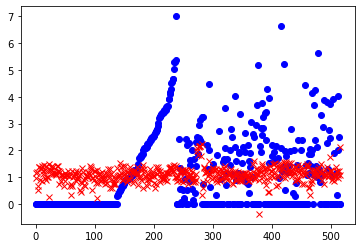

In [30]:
plt.plot(Tlog, 'ob')
plt.plot(Y, 'xr')

It turns out our RMSE value is not so great. One good indication of a potentially high RMSE is when the mean and STD values are almost equal. Anytime the mean and STD are relatively close in value this indicates a skewed or heavy tailed distribution (exactly what we noticed last week when plotting the histogram for `T` and `Tlog`). It seems that even when taking the log of `T` the heavy tailed distribution of our data still distorts our results.

The next question is why does a heavy tailed distribution distort our results? This relates to the issue of data balance. If we recall many of our target values (burned forest area values) were 0. Thus, many of our data samples indicated 0 burned forest area. This can influence our predictions by biasing the algorithm towards predicting values closer to 0. We’ll take a closer look at data imbalance in the near future, for now keep this idea in the back of your head.

Let's now print the weights. What do you think the weight values represent? One might be tempted to think that these weights represent the significance of their corresponding feature. For instance, if the third weight is negative one might assume that the algorithm is negatively valuing the third feature. Weights can be thought of in this manner however only when all features share a similar numerical scale. It turns out that our features do not currently share a similar numerical scale!

In [31]:
w

array([-0.30477203,  0.0425947 , -0.00129011,  0.1550639 ,  0.00862479,
        0.00502995,  0.00240059, -0.00119776, -0.02492829,  0.00730238,
       -0.00418998,  0.05759247,  0.08504343])

# Normalization

Let's take a look at our input distribution below. We can easily observe that each feature is operating with a different scale by looking at the mean and standard deviation (STD). Having different scales for each input feature causes many ML models difficulty when trying to learn the optimal weights.

Different scales across input features means some weights have small values (indicated by having a small mean and STD) and need finer updates, smaller changes to their weights. Meanwhile, other weights have larger values (indicated by having a larger mean and STD) and need larger updates, larger changes to their weights. Thus, it can be helpful to normalize the input features all to the same scale, which is called normalization.

In [32]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


One normalization trick we often use is called standardization. Standardization transforms our data to have a zero mean and unit variance. When standardizing our data we simply subtract each feature by its mean and divide by its standard deviation. For instance, if we wanted to standardize the `rain` column we would subtract the mean of the `rain` column from every point in the `rain` column and then divide all points in the `rain` column by the STD of the `rain` column.

$\frac{rain - mean(rain)}{STD(rain)}$

We can generalize these computations to every column in `X` thanks to linear algebra and Numpy. To calculate the mean and STD we simply input `X` into the Numpy functions `np.mean()` and `np.std()`. We then have to specify the 'axis' parameter within these functions to compute the mean and STD per column. If `axis=0` then we are looking to compute the `np.mean()` and `np.std()` column wise, i.e. per each feature. Likewise, if `axis=1`then we are looking to compute the `np.mean()` and `np.std()` row wise, i.e. per each data sample.

### TODO

- Use `np.mean` and `np.std` and the axis parameter to compute the mean and STD for each column, feature, in `X`. Store the mean in `mu` and the STD in `std`.
- Using `mu` and `std` calculate the standardized values of `X` and store them in `normX`.

In [33]:
# TODO: Calculate mean and std
mu = np.mean(X, axis=0)
std = np.std(X, axis=0)

In [34]:
# TODO: Calculate standardized values of X
normX = (X - mu) / std
pd.DataFrame(normX).describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02
mean,2.113074e-16,2.611279e-16,-1.030768e-16,8.589733e-17,-1.752306e-15,-2.748715e-17,6.871787e-17,1.030768e-17,2.542561e-16,2.198972e-16,-4.191790e-16,-6.871787e-18
std,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00
min,-1.587360e+00,-1.871724e+00,-2.848033e+00,-1.573785e+00,-1.304582e+01,-1.715608e+00,-2.179108e+00,-1.980578e+00,-2.876943e+00,-1.796637e+00,-2.021098e+00,-7.326831e-02
25%,-7.221360e-01,-2.440010e-01,-2.092640e-01,-1.090909e+00,-8.063453e-02,-6.606652e-01,-4.448281e-01,-5.535954e-01,-5.842379e-01,-6.924563e-01,-7.361236e-01,-7.326831e-02
50%,-2.895238e-01,-2.440010e-01,2.305307e-01,3.577209e-01,1.732292e-01,-4.020255e-02,4.691190e-01,-1.364774e-01,7.082076e-02,-1.403660e-01,-9.833712e-03,-7.326831e-02
75%,1.008313e+00,5.698604e-01,6.703255e-01,8.405974e-01,4.089598e-01,4.927389e-01,6.696628e-01,3.904086e-01,6.741643e-01,5.344111e-01,4.929823e-01,-7.326831e-02
max,1.873537e+00,3.825306e+00,1.989710e+00,1.323474e+00,1.007353e+00,2.819865e+00,1.261610e+00,1.033538e+01,2.484195e+00,3.417549e+00,3.007063e+00,2.157228e+01


If you want to use Pandas only the solution is as follows.

In [35]:
dfX = pd.DataFrame(X)
mu = dfX.mean() 
std = dfX.std()

In [36]:
norm_dfX = (dfX - mu) / std
norm_dfX.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02
mean,1.632049e-16,2.267690e-16,-5.497429e-17,1.683588e-16,4.202441e-14,-4.672815e-16,1.882870e-15,-7.816657e-16,2.405125e-16,2.061536e-16,-4.191790e-16,-6.871787e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.585825e+00,-1.869913e+00,-2.845277e+00,-1.572262e+00,-1.303319e+01,-1.713948e+00,-2.177000e+00,-1.978662e+00,-2.874160e+00,-1.794899e+00,-2.019142e+00,-7.319742e-02
25%,-7.214373e-01,-2.437649e-01,-2.090616e-01,-1.089853e+00,-8.055651e-02,-6.600260e-01,-4.443977e-01,-5.530598e-01,-5.836726e-01,-6.917863e-01,-7.354113e-01,-7.319742e-02
50%,-2.892437e-01,-2.437649e-01,2.303076e-01,3.573748e-01,1.730616e-01,-4.016365e-02,4.686651e-01,-1.363453e-01,7.075224e-02,-1.402302e-01,-9.824197e-03,-7.319742e-02
75%,1.007337e+00,5.693090e-01,6.696769e-01,8.397841e-01,4.085641e-01,4.922622e-01,6.690148e-01,3.900308e-01,6.735120e-01,5.338940e-01,4.925053e-01,-7.319742e-02
max,1.871724e+00,3.821605e+00,1.987784e+00,1.322193e+00,1.006378e+00,2.817136e+00,1.260389e+00,1.032538e+01,2.481791e+00,3.414243e+00,3.004153e+00,2.155141e+01


### TODO
Let's re-add our bias term to our newly normalized inputs.
* Add the bias term, a vector of 1s, to the first column of `normX` and store the result in a new variable called `X1s`.
* Recompute the least squares solution using the normalized matrix `X1s` and `Tlog` storing the new weights in `w_s`
* Calcualte the new predictions and store in `Ys` using `X1s` and `w_s`

In [37]:
# TODO: Add the bias term
X1s = np.hstack((np.ones((N, 1)), normX)) 

In [38]:
""" 
The following code also works

w_s = np.linalg.lstsq(X1s.T @ X1s, X1s.T @ Tlog)[0]
"""
# TODO: Recompute the least squares solution using the normalized matrix `X1s`
X1s_inverse = np.linalg.pinv(X1s.T @ X1s)
w_s = X1s_inverse @ X1s.T @ Tlog

In [39]:
# TODO: Calcualte the predictions
Ys = X1s @ w_s

In [40]:
# Computes RMSE
np.sqrt(np.mean((Tlog- Ys)**2))

1.3704029873585828

Let's plot the results and see if our solution is better than the previous solution.

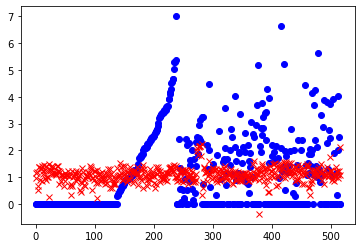

In [41]:
plt.plot(Tlog, 'ob')
plt.plot(Ys, 'xr')

Run the code below to print the new weights as well.

In [42]:
w_s

array([ 1.11102577,  0.09845931, -0.00158518,  0.35258243,  0.01786126,
        0.02773904,  0.15360069, -0.29683741, -0.11355001,  0.04236118,
       -0.06830369,  0.10308585,  0.02514502])

Welp, it doesn't seem our predictions are all that much better. At least now we can say that our weights represent the significance of their corresponding feature!

# Indicator Variables
Well, as we observed above, normalization did not help in this data. This forest fire problem might just be a little hard for a linear model. Although it is not successful, it is good to learn normalization as it gives you better results in many cases. 

Now, we can practice one more useful trick, indicator variables. When we observe some categorical variables, sometimes scale is often not reasonable. For instance, let us assume we have the inputs of cat or dog.  Is it reasonable if we allocate 1 to cat and 2 to dog? Can we say that dog $>$ cat as 2 $>$ 1? No, we can't. For this reason, we convert the categorical values to indicator variables or one-hot encodings. Instead of 1 or 2 for cat or dog, we use vector representations. For instance, `[0, 1]` could be for cat and `[1, 0]` could be for dog. 

Follow the code for how we can covert the string values into indicator variables using `pd.get_dummies()` function in Pandas.

In [43]:
df.loc[:,'month']

0      mar
1      oct
2      oct
3      mar
4      mar
      ... 
512    aug
513    aug
514    aug
515    aug
516    nov
Name: month, Length: 517, dtype: object

In [44]:
indicator_month = pd.get_dummies(df.loc[:, 'month'])
indicator_month

,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
512,0,1,0,0,0,0,0,0,0,0,0,0
513,0,1,0,0,0,0,0,0,0,0,0,0
514,0,1,0,0,0,0,0,0,0,0,0,0
515,0,1,0,0,0,0,0,0,0,0,0,0


In [45]:
df.loc[:,'day']

0      fri
1      tue
2      sat
3      fri
4      sun
      ... 
512    sun
513    sun
514    sun
515    sat
516    tue
Name: day, Length: 517, dtype: object

In [46]:
indicator_day = pd.get_dummies(df.loc[:, 'day'])
indicator_day

,fri,mon,sat,sun,thu,tue,wed
0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
512,0,0,0,1,0,0,0
513,0,0,0,1,0,0,0
514,0,0,0,1,0,0,0
515,0,0,1,0,0,0,0


In [47]:
df.columns.values

array(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'], dtype=object)

Here, we stitch our original data `df` back together, now with the new indicator variables, using concat. We printed out the column names above to recall where 'month' and 'day' belong in the data.

In [48]:
X = pd.concat([
        df.iloc[:, :2], 
        indicator_month, 
        indicator_day,
        df.iloc[:, 4:-1]],
        axis=1)
X

,X,Y,apr,aug,dec,feb,jan,jul,jun,mar,...,tue,wed,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,0,0,0,0,0,0,0,1,...,0,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,0,0,0,0,0,0,0,0,...,1,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,0,0,0,0,0,0,0,0,...,0,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,0,0,0,0,0,0,0,1,...,0,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,0,0,0,0,0,0,0,1,...,0,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,0,1,0,0,0,0,0,0,...,0,0,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,0,1,0,0,0,0,0,0,...,0,0,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,0,1,0,0,0,0,0,0,...,0,0,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,0,1,0,0,0,0,0,0,...,0,0,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


Before we run LS again we need to normalize the data again, as seen below.

In [49]:
X = X.values # Converts Pandas DataFrame back to Numpy array
mu = np.mean(X, axis=0)
std = np.std(X, axis=0)

In [50]:
normX = (X - mu) / std
pd.DataFrame(normX).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,5.170000e+02,5.170000e+02,517.000000,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,...,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02
mean,2.113074e-16,2.611279e-16,0.000000,8.246144e-17,-6.871787e-17,2.061536e-17,2.233331e-17,-1.374357e-17,-1.374357e-17,-8.246144e-17,...,5.153840e-18,1.030768e-17,-1.752306e-15,-2.748715e-17,6.871787e-17,1.030768e-17,2.542561e-16,2.198972e-16,-4.191790e-16,-6.871787e-18
std,1.000969e+00,1.000969e+00,1.000969,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,...,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00
min,-1.587360e+00,-1.871724e+00,-0.133103,-7.433388e-01,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,...,-3.758728e-01,-3.415123e-01,-1.304582e+01,-1.715608e+00,-2.179108e+00,-1.980578e+00,-2.876943e+00,-1.796637e+00,-2.021098e+00,-7.326831e-02
25%,-7.221360e-01,-2.440010e-01,-0.133103,-7.433388e-01,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,...,-3.758728e-01,-3.415123e-01,-8.063453e-02,-6.606652e-01,-4.448281e-01,-5.535954e-01,-5.842379e-01,-6.924563e-01,-7.361236e-01,-7.326831e-02
50%,-2.895238e-01,-2.440010e-01,-0.133103,-7.433388e-01,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,...,-3.758728e-01,-3.415123e-01,1.732292e-01,-4.020255e-02,4.691190e-01,-1.364774e-01,7.082076e-02,-1.403660e-01,-9.833712e-03,-7.326831e-02
75%,1.008313e+00,5.698604e-01,-0.133103,1.345282e+00,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,...,-3.758728e-01,-3.415123e-01,4.089598e-01,4.927389e-01,6.696628e-01,3.904086e-01,6.741643e-01,5.344111e-01,4.929823e-01,-7.326831e-02
max,1.873537e+00,3.825306e+00,7.512952,1.345282e+00,7.512952e+00,4.984977e+00,1.604681e+01,3.893103e+00,5.423261e+00,2.928152e+00,...,2.660475e+00,2.928152e+00,1.007353e+00,2.819865e+00,1.261610e+00,1.033538e+01,2.484195e+00,3.417549e+00,3.007063e+00,2.157228e+01


In [51]:
normX.shape

(517, 29)

### TODO
Let's re-add our bias term to our new data which contains the indicator variables and is normalized.

* Add the bias term, a vector of 1s, to the first column of `normX` and store the result in a new variable called `X1i`.
* Recompute the least squares solution using the normalized matrix `X1i` and `Tlog` storing the new weights in `w_i`
* Calculate the new predictions and store in `Yi` using `X1i` and `w_i`


In [52]:
# TODO: Add the bias term
X1i = np.hstack((np.ones((N, 1)), normX)) 

In [53]:
""" 
The following code also works

w_i = np.linalg.lstsq(X1i.T @ X1i, X1i.T @ Tlog)[0]
"""
# TODO: Recompute the least squares solution using the normalized matrix `X1i`
X1i_inverse = np.linalg.pinv(X1i.T @ (X1i))
w_i = X1i_inverse @ X1i.T @ Tlog

In [54]:
# TODO: Calcualte the new predictions
Yi = X1i @ w_i

In [55]:
# Computes RMSE
np.sqrt(np.mean((Tlog- Yi)**2))

1.3442088524180986

Let's plot the results and see if our solution is better than the previous solution.

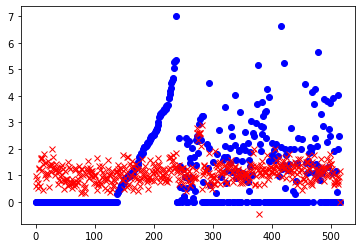

In [56]:
plt.plot(Tlog, 'ob')
plt.plot(Yi, 'xr')


# Better? What's next?

Well, still it looks poor. However, our predictions have begun to spread out a tad bit more than before.

Now would probably be good time try the other ML models, ones that are more flexible or sophisticated. We'll dicuss such models in the near future but for now let's shift our attention to least mean squares (LMS) and see how it preforms.

# Least Mean Squares 

Let's switch gears and practice LMS, an online learning algorithm. Recall that the following equation is the update rule for slowly moving our weights towards the optimal weights which will give us the best predictions. 

$w^{(k+1)} = w^{(k)} - \alpha(w^{(k)^T} \cdot x_k - t_k) \times x_k$

Here $w$ is a vector of weights corresponding to each input feature before applying a new data sample $k$, $x_k$ is a vector of input features for a given data sample, and $t_k$ is the scalar target for said data sample. **Note, $\cdot$ corresponds to the dot product and $\times$ corresponds to scalar multiplication.**

### SOLUTION NOTE: 
* The mean sqaure difference equation was actually wrong in the original lab, there was a missing parentheses around the square error casuing the mean of the error to be taken and then squared. This has been updated here. No points will be deducted for having a different RMSE graph.

Old update 
`errs.append(np.sqrt(np.mean(Tlog - Y_lms)**2))`

New update
`errs.append(np.sqrt(np.mean((Tlog - Y_lms)**2)))`

### TODO
Let's practice by adding LMS weight update and target prediction to the code below.

* Add the LMS online update solution indexing `Xli` and `Tlog` one data sample at a time 
* Use the current weights `w_lms` to make predictions for all of `Xli`

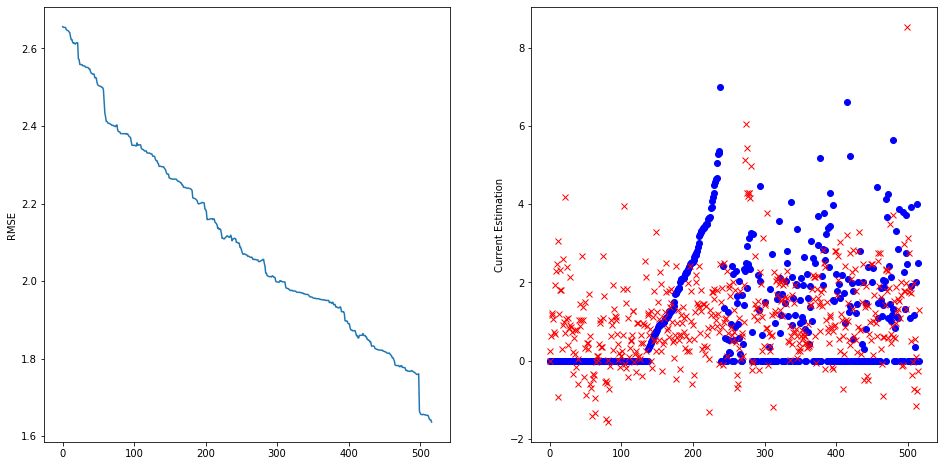

In [57]:
import IPython.display as ipd  # for display and clear_output


# Read one by one and update weights 
alpha = 0.001 

w_lms = np.random.rand(X1i.shape[1])

fig = plt.figure(figsize=(16,8))

errs = []
# Read data samples one-by-one making weight updates and predictions 
for k in range(N):
    # TODO: Add the LMS online update 
    w_lms -= alpha * (w_lms.T @ X1i[k] - Tlog[k]) * X1i[k]
    
    # TODO: Use the current weights `w_lms` to make predictions for all of `Xli`
    Y_lms = X1i @ w_lms
    errs.append(np.sqrt(np.mean((Tlog - Y_lms)**2)))
    
    plt.clf()
    plt.subplot(1, 2, 1)
    plt.plot(errs) # blue line left graph
    plt.ylabel("RMSE")
    
    plt.subplot(1,2, 2)
    plt.plot(Tlog[:k], 'ob') # blue line right graph
    plt.plot(Y_lms[:k], 'xr') # orange line right graph
    plt.ylabel("Current Estimation")
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)

Here we can observe our RMSE error for LMS.

In [58]:
print("RMSE: {0}".format(errs[-1]))

RMSE: 1.6365031867040427


# Partitioning Data 

So far we have seen how the LS and LMS models preform on our forest fire dataset. Throughout this lab we have been evaluating our models using the data we trained on. This is not typically useful as we want to know how our model will preform on unseen data. Given the limited size of data, we often simulate unseen data by simply partitioning our data into a training and testing set. Here the training set is used exclusively for training and the testing set acts as our unseen data we want to make predictions on.

Read the function `partition()` below and try to understand how the data is partitioned into training and testing sets. 

In [59]:
# now partition the data 

""" partitioning data

    parameters
    -----------
    X        pd.DataFrame
             input data to partition
    T        pd.DataFrame
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Shuffle the data indices 
    idxs = np.random.permutation(X.index)
    
    # Store the number of data samples 
    N = X.shape[0]
    
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
        nrows = int(round(N * r)) 
        
        # If we are on the last ratio simply use the remaining data samples
        if k == len(ratio)-1:
            Xs.append(X.iloc[i:, :])
            Ts.append(T.iloc[i:, :])
        else:
            Xs.append(X.iloc[i:i+nrows, :])
            Ts.append(T.iloc[i:i+nrows, :])
        
        i += nrows
    
    return Xs, Ts

In [60]:
Xlst, Tlst = partition(pd.DataFrame(X1i), pd.DataFrame(Tlog))

In [61]:
# Train data shape
print("Train data shape: {}".format(Xlst[0].shape))
# Train target data shape
print("Train target shape: {}".format(Tlst[0].shape))

Train data shape: (414, 30)
Train target shape: (414, 1)


In [62]:
# Test data shape
print("Test data shape: {}".format(Xlst[1].shape))
# Test target data shape
print("Test target shape: {}".format(Tlst[1].shape))

Test data shape: (103, 30)
Test target shape: (103, 1)


### TODO
Use the training set for training the LMS model and then apply the learned weights to the test set to evaluate the performance. 

* Create the following variables `Xtrain` and `Ttrain` for training and `Xtest` and `Ttest` for testing
    * Hint: split the lists `Xlst` and `Tlst` into separate variables
* Compute the LMS online update of weight `w` using `Xtrain` and `Ttrain`
* Compute and store the predictions into `Yp` using `w` and `Xtest`

In [82]:
alpha = 0.001 

# TODO: create (Xtrain, Ttrain) for training and (Xtest, Ttest) for testing
Xtrain, Xtest = [xx.values for xx in Xlst]
Ttrain, Ttest = [tt.values for tt in Tlst]

# Random initialization of weight w 
# np.random.seed(0) # Setting the seed ensures we get the same RMSE output and predictions
w = np.random.rand(Xtrain.shape[1], Ttrain.shape[1])

fig = plt.figure(figsize=(16,8))

errs = []
# Read data samples one by one and update weights 
for i in range(Xtrain.shape[0]):
    # TODO: Compute the LMS online update
    w -= (alpha *(w.T @ Xtrain[0] - Ttrain[0]) * Xtrain[0]).reshape(w.shape)
# TODO: Compute and store the predictions   
Yp = Xtest @ w
np.sqrt(np.mean((Yp -  Ttest)**2)) # RMSE of test data partition

2.906817100339354

<Figure size 1152x576 with 0 Axes>

In [69]:
Ttrain[0].shape

(1,)

Plot the LMS predictions using the code below. Notice, that each time we rerun the LMS calculations we get a new RMSE and different predictions. This is because we randomly initialize the weights every time we rerun the LMS calculations and thus our weights converge to slightly different answers each time (the order in which the data is presented can also influence our RMSE).

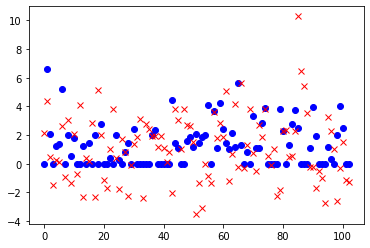

In [64]:
plt.plot(Ttest, 'ob')
plt.plot(Yp, 'xr')

### TODO
Use the training set for training the LS model and then apply the learned weights to the test set to evaluate the performance. 

- Compute the LS weights `w` using `Xtrain` and `Ttrain`
- Compute and store the predictions into `Yp2` using `w` and `Xtest`

In [65]:
# TODO: Compute the LS weights
Xtrain_inverse = np.linalg.pinv(Xtrain.T @ Xtrain)
w = Xtrain_inverse @ Xtrain.T @ Ttrain

# TODO: Compute and store the predictions into `Yp2`
Yp2 = Xtest @ w
np.sqrt(np.mean((Yp2 -  Ttest)**2))

1.9619284663381849

Plot the LS predictions using the code below.

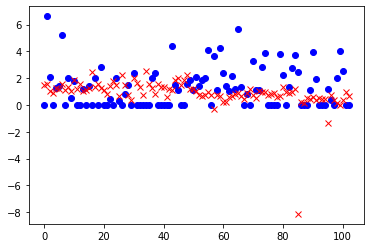

In [66]:
plt.plot(Ttest, 'ob')
plt.plot(Yp2, 'xr')